In [1]:
# =============================================================================
# 0. IMPORTS AND SETTINGS
# =============================================================================
import sys, os, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pymc as pm, arviz as az

os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

from data_utils import load_and_prepare_data
from metadata import theory_order, theory_map

# Load and preprocess data
df, concepts = load_and_prepare_data("../data/final_dataset.csv")


In [ ]:
# =============================================================================
# 1. CHEATING BEHAVIOR DISTRIBUTION BY CONCEPT
# =============================================================================
cheating_dist = pd.crosstab(df['concept'], df['cheating_behavior'], margins=True)
cheating_dist.columns = ['Non-cheater','Partial-cheater','Full-cheater','Total']

print("Cheating Behavior Distribution by Concept:")
print("="*60)

for concept in ['control'] + concepts:
    if concept in cheating_dist.index:
        row = cheating_dist.loc[concept]
        print(f"{concept:<25} | Non: {row[0]:>3} ({row[0]/row['Total']*100:>4.1f}%) | "
              f"Partial: {row[1]:>3} ({row[1]/row['Total']*100:>4.1f}%) | "
              f"Full: {row[2]:>3} ({row[2]/row['Total']*100:>4.1f}%) | Total: {row['Total']:>3}")

print("-"*60)
total_row = cheating_dist.loc['All']
print(f"{'OVERALL':<25} | Non: {total_row[0]:>3} ({total_row[0]/total_row['Total']*100:>4.1f}%) | "
      f"Partial: {total_row[1]:>3} ({total_row[1]/total_row['Total']*100:>4.1f}%) | "
      f"Full: {total_row[2]:>3} ({total_row[2]/total_row['Total']*100:>4.1f}%) | Total: {total_row['Total']:>3}")

Fitting RQ1: Cheating Behavior Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, mu_partial, sigma_partial, concept_effects_partial, mu_full, sigma_full, concept_effects_full]


Output()

Sampling 4 chains for 2_500 tune and 1_500 draw iterations (10_000 + 6_000 draws total) took 351 seconds.
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta_full_intercept, beta_partial_intercept, cheating_observed, concept_effects_full, concept_effects_partial, mu_full, mu_partial, sigma_full, sigma_partial]
Sampling: [cheating_observed]


Output()

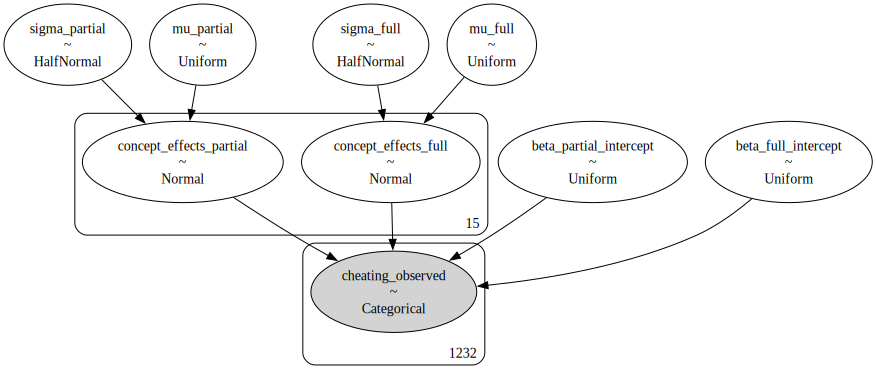

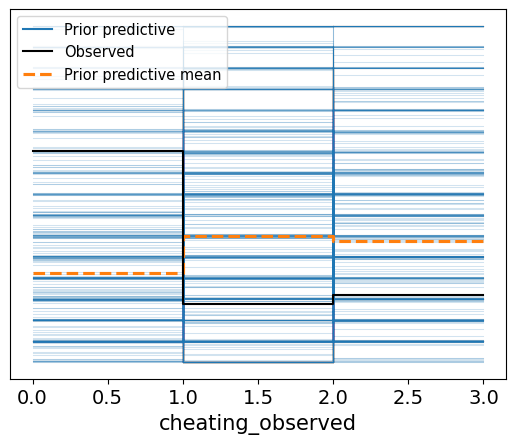

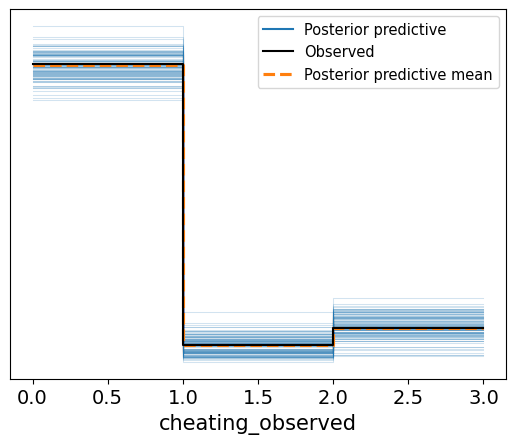

In [10]:
# =============================================================================
# 2. RQ1: CHEATING BEHAVIOR MODEL
# =============================================================================

def build_cheating_model(df, concepts, B=100.0):
    with pm.Model() as model:
        # Intercepts: rectangular/uniform priors
        beta_partial = pm.Uniform('beta_partial_intercept', lower=-B, upper=B)
        beta_full    = pm.Uniform('beta_full_intercept',    lower=-B, upper=B)

        # Concept-level effects (hierarchical structure kept)
        def concept_effects(name):
            # Uniform prior on group-level mean
            mu = pm.Uniform(f'mu_{name}', lower=-B, upper=B)
            # keep a proper prior for the sd (positive)
            sigma = pm.HalfNormal(f'sigma_{name}', sigma=100)
            # concept-specific effects (proper, bounded via mu/sigma behaviour)
            return pm.Normal(f'concept_effects_{name}', mu=mu, sigma=sigma, shape=len(concepts))

        concept_partial, concept_full = concept_effects('partial'), concept_effects('full')

        # Linear logits (unchanged)
        idx = df['concept_idx'].values
        partial_fx = pm.math.switch(idx>0, concept_partial[idx-1], 0)
        full_fx    = pm.math.switch(idx>0, concept_full[idx-1], 0)

        logits = pm.math.stack([
            pm.math.zeros_like(partial_fx),
            beta_partial + partial_fx,
            beta_full    + full_fx
        ], axis=1)

        pm.Categorical('cheating_observed',
                       p=pm.math.softmax(logits, axis=1),
                       observed=df['cheating_behavior'].values)
    return model

def sample_model(model, draws=1500, tune=2500, chains=4, cores=4, target_accept=0.95, max_treedepth=12, init="jitter+adapt_diag", random_seed=42):
    with model:
        return pm.sample(draws=draws, tune=tune, chains=chains, cores=cores,
                         target_accept=target_accept, max_treedepth=max_treedepth, init=init, random_seed=random_seed)

print("Fitting RQ1: Cheating Behavior Model...")
cheating_model = build_cheating_model(df, concepts)
trace_cheating = sample_model(cheating_model)
az.to_netcdf(trace_cheating, "notebook/trace_cheating.nc")

# Posterior Predictive Check
with cheating_model:
    ppc_prior = pm.sample_prior_predictive()
    ppc_post = pm.sample_posterior_predictive(trace_cheating, random_seed=42)
az.plot_ppc(ppc_prior, group='prior', observed=True)
az.plot_ppc(ppc_post, num_pp_samples=100)

pm.model_to_graphviz(cheating_model)

In [20]:
# =============================================================================
# AFTER SAMPLING: EXTRACT POSTERIOR ARRAYS ONCE
# =============================================================================

beta_partial = trace_cheating.posterior['beta_partial_intercept'].values.flatten()
beta_full = trace_cheating.posterior['beta_full_intercept'].values.flatten()
partial_fx = trace_cheating.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
full_fx = trace_cheating.posterior['concept_effects_full'].values.reshape(-1, len(concepts))

# --- CONTROL PROBABILITIES ---
control_logits = np.column_stack([np.zeros_like(beta_partial), beta_partial, beta_full])
control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)

# --- HDIs for control ---
control_hdi = az.hdi(control_probs, hdi_prob=0.89)

# --- FUNCTION TO COMPUTE CONCEPT PROBS AND HDIs ---
def concept_probs_and_hdi(idx):
    logits = np.column_stack([
        np.zeros_like(beta_partial),
        beta_partial + partial_fx[:, idx],
        beta_full + full_fx[:, idx]
    ])
    probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    diffs = probs - control_probs  # difference from control
    hdi_vals = az.hdi(diffs, hdi_prob=0.89)
    mean_diff = diffs.mean(axis=0)
    return probs, diffs, mean_diff, hdi_vals

# =============================================================================
# CREATE POSTERIOR PREDICTIVE DATAFRAMES FOR PLOTTING
# =============================================================================

# Control group posterior probabilities (already calculated)
posterior_preds_control = pd.DataFrame({
    'Non-cheaters': control_probs[:, 0],
    'Partial-cheaters': control_probs[:, 1],
    'Full-cheaters': control_probs[:, 2]
})

# Intervention group posterior probabilities (averaged across all concepts)
intervention_logits = np.column_stack([
    np.zeros_like(beta_partial),
    beta_partial + partial_fx.mean(axis=1),  # Average effect across concepts
    beta_full + full_fx.mean(axis=1)
])
intervention_probs = np.exp(intervention_logits) / np.exp(intervention_logits).sum(axis=1, keepdims=True)

posterior_preds_intervention = pd.DataFrame({
    'Non-cheaters': intervention_probs[:, 0],
    'Partial-cheaters': intervention_probs[:, 1],
    'Full-cheaters': intervention_probs[:, 2]
})

print("✓ Posterior predictive DataFrames created")
print(f"  Control shape: {posterior_preds_control.shape}")
print(f"  Intervention shape: {posterior_preds_intervention.shape}")

✓ Posterior predictive DataFrames created
  Control shape: (6000, 3)
  Intervention shape: (6000, 3)


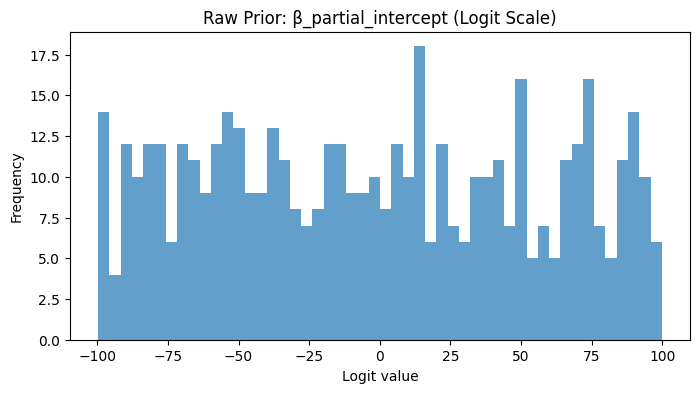

=== DIAGNOSTIC CHECK ===
Shape: (6000, 3)

Means (should all be ~0.333):
  NC: 0.3365
  PC: 0.3315
  FC: 0.3320

Std devs:
  NC: 0.2386
  PC: 0.2351
  FC: 0.2338

Min/Max:
  NC: [0.000, 0.987]
  PC: [0.000, 0.986]
  FC: [0.000, 0.989]


In [61]:
# =========================================================
# logit scale prior check
# =========================================================
prior_samples = ppc_prior.prior['beta_full_intercept'].values.flatten()

plt.figure(figsize=(8, 4))
plt.hist(prior_samples, bins=50, alpha=0.7)
plt.title('Raw Prior: β_partial_intercept (Logit Scale)')
plt.xlabel('Logit value')
plt.ylabel('Frequency')
plt.show()

# =============================================================================
# DIAGNOSTIC CHECK --- IGNORE ---
# =============================================================================

n_samples = 6000
prior_control = np.random.dirichlet([1, 1, 1], size=n_samples)

print("=== DIAGNOSTIC CHECK ===")
print(f"Shape: {prior_control.shape}")
print(f"\nMeans (should all be ~0.333):")
print(f"  NC: {prior_control[:, 0].mean():.4f}")
print(f"  PC: {prior_control[:, 1].mean():.4f}")
print(f"  FC: {prior_control[:, 2].mean():.4f}")
print(f"\nStd devs:")
print(f"  NC: {prior_control[:, 0].std():.4f}")
print(f"  PC: {prior_control[:, 1].std():.4f}")
print(f"  FC: {prior_control[:, 2].std():.4f}")
print(f"\nMin/Max:")
print(f"  NC: [{prior_control[:, 0].min():.3f}, {prior_control[:, 0].max():.3f}]")
print(f"  PC: [{prior_control[:, 1].min():.3f}, {prior_control[:, 1].max():.3f}]")
print(f"  FC: [{prior_control[:, 2].min():.3f}, {prior_control[:, 2].max():.3f}]")

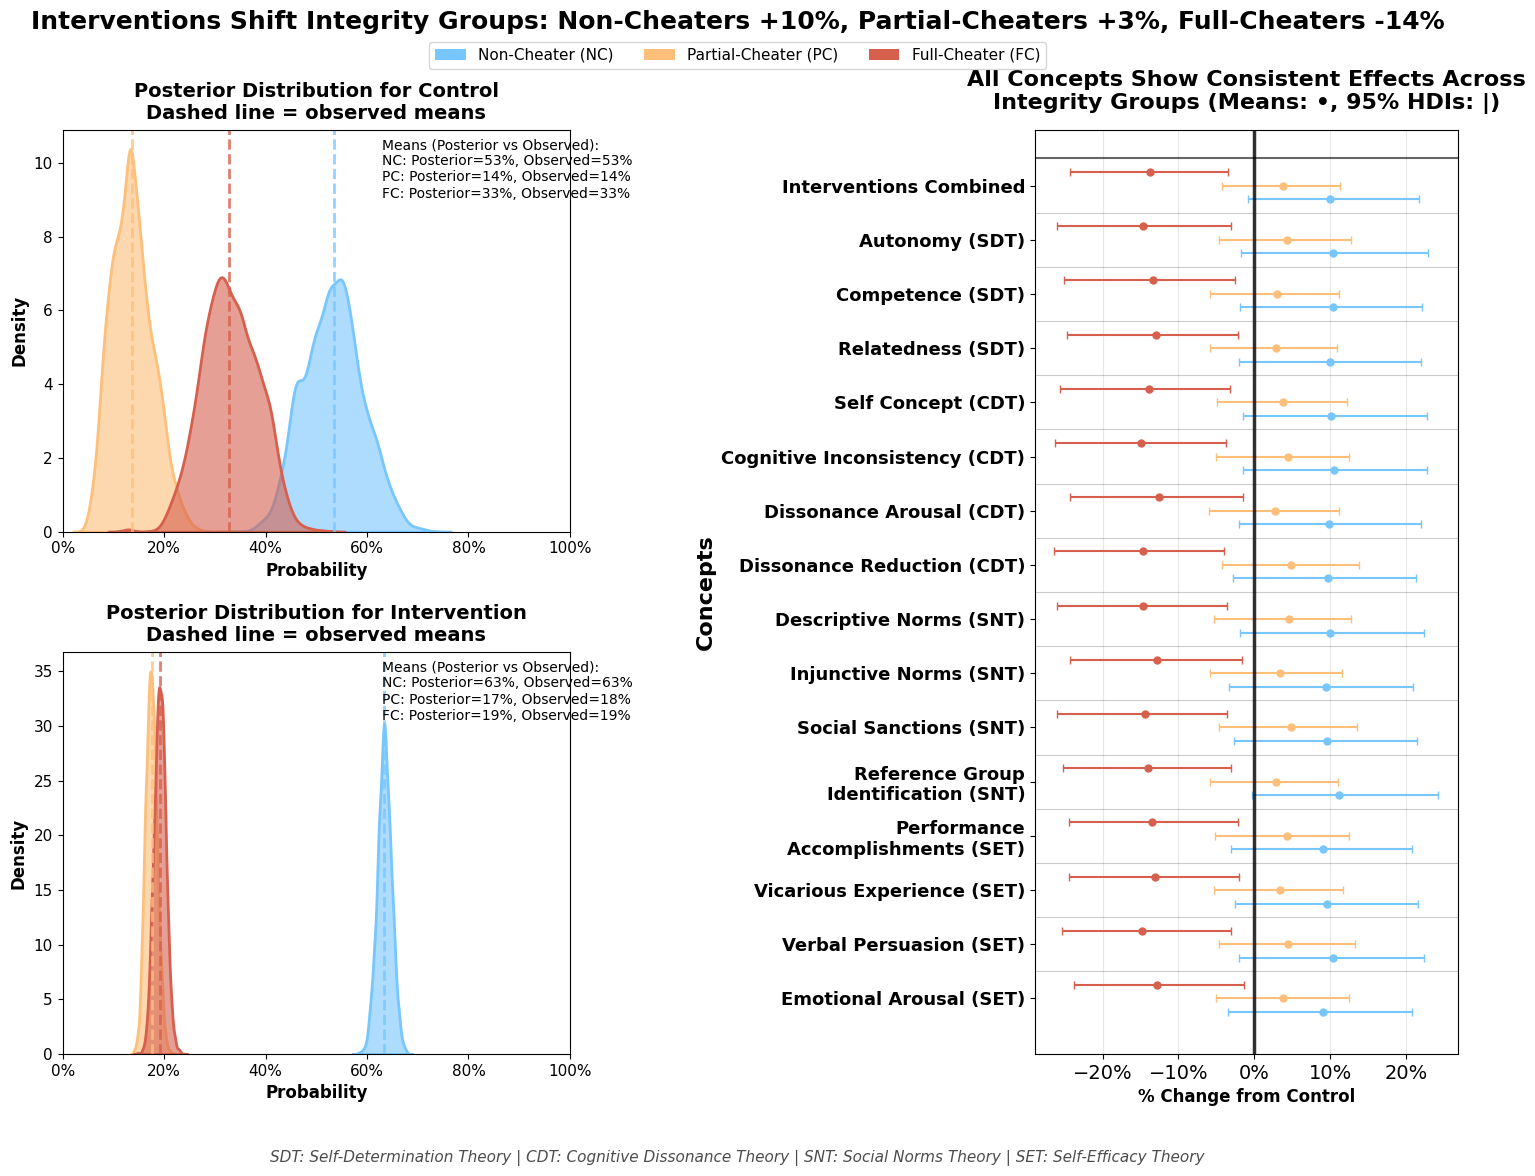

In [ ]:
# =============================================================================
# 3. COMBINED VISUALIZATION FUNCTION
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib import gridspec

def plot_bayesian_validation_combined(trace_cheating, ppc_prior, df, concepts, theory_order, theory_map):
    """
    Combined visualization:
      Left panels (2 rows): Posterior predictive distributions for Control and Intervention
      Right panel: Impact spectrum forest plot showing effect sizes across concepts
    """
    
    # =========================================================================
    # EXTRACT POSTERIOR SAMPLES
    # =========================================================================
    beta_partial = trace_cheating.posterior['beta_partial_intercept'].values.flatten()
    beta_full = trace_cheating.posterior['beta_full_intercept'].values.flatten()
    partial_fx = trace_cheating.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
    full_fx = trace_cheating.posterior['concept_effects_full'].values.reshape(-1, len(concepts))
    
    # Extract prior samples
    prior_partial = ppc_prior.prior['beta_partial_intercept'].values.flatten()
    prior_full = ppc_prior.prior['beta_full_intercept'].values.flatten()
    prior_partial_fx = ppc_prior.prior['concept_effects_partial'].values.reshape(-1, len(concepts))
    prior_full_fx = ppc_prior.prior['concept_effects_full'].values.reshape(-1, len(concepts))
    
    # Softmax conversion function
    def to_probs(logits):
        exp_logits = np.exp(logits)
        return exp_logits / exp_logits.sum(axis=1, keepdims=True)
    
    # Calculate probability distributions
    control_probs = to_probs(np.column_stack([np.zeros_like(beta_partial), beta_partial, beta_full]))
    intervention_probs = to_probs(np.column_stack([
        np.zeros_like(beta_partial),
        beta_partial + partial_fx.mean(axis=1),
        beta_full + full_fx.mean(axis=1)
    ]))
    
    # Observed proportions
    control_obs = df[df['concept'] == 'control']['cheating_behavior'].value_counts(normalize=True).sort_index()
    intervention_obs = df[df['concept'] != 'control']['cheating_behavior'].value_counts(normalize=True).sort_index()
    
    # =========================================================================
    # SETUP FIGURE WITH 3 SUBPLOTS (2 left, 1 right)
    # =========================================================================
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1.2, 1], height_ratios=[1, 1], 
                          wspace=1, hspace=0.3)
    
    ax_control = plt.subplot(gs[0, 0])
    ax_intervention = plt.subplot(gs[1, 0])
    ax_impact = plt.subplot(gs[:, 1])
    
    # =========================================================================
    # LEFT PANELS: POSTERIOR PREDICTIVE DISTRIBUTIONS
    # =========================================================================
    categories = ['Non-Cheater (NC)', 'Partial-Cheater (PC)', 'Full-Cheater (FC)']
    short_cats = ['NC', 'PC', 'FC']
    colors = ['#78c6fe', '#fdbf7a', '#d6604d']
    
    def plot_posterior_distribution(ax, post_data, obs_data, group_data, title):
        """Plot KDE distributions with observed means and N labels"""
        group_counts = group_data['cheating_behavior'].value_counts().sort_index()
        plot_means = []
        obs_means = []
        
        for i, (cat, sc, color) in enumerate(zip(categories, short_cats, colors)):
            # Plot KDE
            sns.kdeplot(post_data[:, i], ax=ax, color=color, fill=True, 
                       alpha=0.6, linewidth=2)
            plot_mean = post_data[:, i].mean()
            plot_means.append(plot_mean)
            
            # Observed mean line
            if i in obs_data.index:
                obs_mean = obs_data.iloc[i]
                obs_means.append(obs_mean)
                ax.axvline(obs_mean, color=color, linestyle='--', linewidth=2, alpha=0.8)
                
                # N label near each curve
                # ax.text(obs_mean + 0.02, ax.get_ylim()[1] * (0.85 - i*0.15),
                #        f"N = {group_counts.get(i, 0)}", fontsize=11, fontweight='bold',
                #        color=color, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
        
        ax.set_title(f"{title}\nDashed line = observed means", fontweight='bold', fontsize=14, pad=8)
        ax.set_xlim(0, 1)
        ax.set_xlabel('Probability', fontsize=12, fontweight='bold')
        ax.set_ylabel('Density', fontsize=12, fontweight='bold')
        ax.tick_params(axis='both', labelsize=11)
        ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
        ax.grid(False)
        
        # Stats text box
        stats_text = '\n'.join([f'{sc}: Posterior={post:.0%}, Observed={obs:.0%}' 
                               for sc, post, obs in zip(short_cats, plot_means, obs_means)])
        ax.text(0.63, 0.98, f'Means (Posterior vs Observed):\n{stats_text}',
               transform=ax.transAxes, va='top', fontsize=10)
    
    # Plot control
    control_group = df[df['concept'] == 'control']
    plot_posterior_distribution(ax_control, control_probs, control_obs, 
                               control_group, 'Posterior Distribution for Control')
    
    # Plot intervention
    intervention_group = df[df['concept'] != 'control']
    plot_posterior_distribution(ax_intervention, intervention_probs, intervention_obs,
                               intervention_group, 'Posterior Distribution for Intervention')
    
    # =========================================================================
    # RIGHT PANEL: IMPACT SPECTRUM FOREST PLOT
    # =========================================================================
    concept_display_names = {
        'autonomy': 'Autonomy (SDT)',
        'competence': 'Competence (SDT)',
        'relatedness': 'Relatedness (SDT)',
        'self_concept': 'Self Concept (CDT)',
        'cognitive_inconsistency': 'Cognitive Inconsistency (CDT)',
        'dissonance_arousal': 'Dissonance Arousal (CDT)',
        'dissonance_reduction': 'Dissonance Reduction (CDT)',
        'descriptive_norms': 'Descriptive Norms (SNT)',
        'injunctive_norms': 'Injunctive Norms (SNT)',
        'social_sanctions': 'Social Sanctions (SNT)',
        'reference_group_identification': 'Reference Group\nIdentification (SNT)',
        'performance_accomplishments': 'Performance\nAccomplishments (SET)',
        'vicarious_experience': 'Vicarious Experience (SET)',
        'verbal_persuasion': 'Verbal Persuasion (SET)',
        'emotional_arousal': 'Emotional Arousal (SET)'
    }
    
    # Collect effect data for individual concepts
    concept_rows = []
    theory_groups = {}
    
    for concept in theory_order:
        if concept not in concepts:
            continue
        idx = concepts.index(concept)
        display_name = concept_display_names.get(concept, concept.replace('_', ' ').title())
        theory = theory_map[concept]
        
        if theory not in theory_groups:
            theory_groups[theory] = []
        theory_groups[theory].append(display_name)
        
        # Compute probabilities and % differences
        concept_logits = np.column_stack([
            np.zeros_like(beta_partial),
            beta_partial + partial_fx[:, idx],
            beta_full + full_fx[:, idx]
        ])
        concept_probs = to_probs(concept_logits)
        
        # Calculate differences from control for each group
        for i, group in enumerate(['Non-cheaters', 'Partial-cheaters', 'Full-cheaters']):
            diff = (concept_probs[:, i] - control_probs[:, i]) * 100
            concept_rows.append({
                "concept": display_name,
                "group": group,
                "mean": np.mean(diff),
                "hdi_low": az.hdi(diff, hdi_prob=0.95)[0],
                "hdi_high": az.hdi(diff, hdi_prob=0.95)[1],
                "theory": theory
            })
    
    # Add "Interventions Combined" (overall average across all concepts)
    all_concept_effects = []
    for concept in theory_order:
        if concept not in concepts:
            continue
        idx = concepts.index(concept)
        concept_logits = np.column_stack([
            np.zeros_like(beta_partial),
            beta_partial + partial_fx[:, idx],
            beta_full + full_fx[:, idx]
        ])
        concept_probs = to_probs(concept_logits)
        all_concept_effects.append(concept_probs)
    
    # Average effects across all concepts
    avg_concept_probs = np.mean(all_concept_effects, axis=0)
    
    for i, group in enumerate(['Non-cheaters', 'Partial-cheaters', 'Full-cheaters']):
        diff = (avg_concept_probs[:, i] - control_probs[:, i]) * 100
        concept_rows.append({
            "concept": "Interventions Combined",
            "group": group,
            "mean": np.mean(diff),
            "hdi_low": az.hdi(diff, hdi_prob=0.95)[0],
            "hdi_high": az.hdi(diff, hdi_prob=0.95)[1],
            "theory": "Overall"
        })
    
    df_effects = pd.DataFrame(concept_rows)
    
    # Create ordered concept list by theory
    theory_order_viz = ['Self-Determination Theory', 'Cognitive Dissonance Theory', 
                       'Social Norms Theory', 'Self-Efficacy Theory']
    
    ordered_concepts = []
    for theory in theory_order_viz:
        if theory in theory_groups:
            ordered_concepts.extend(theory_groups[theory])
    
    # Add "Interventions Combined" at the beginning and REVERSE the order
    final_order = ["Interventions Combined"] + ordered_concepts
    final_order = final_order[::-1]  # Reverse so "Interventions Combined" appears at top
    
    # Set categorical order
    df_effects['concept'] = pd.Categorical(df_effects['concept'], categories=final_order, ordered=True)
    df_effects = df_effects.sort_values('concept')
    
    # Get unique concepts in sorted order
    unique_concepts = df_effects['concept'].unique()
    concept_to_y = {concept: i for i, concept in enumerate(unique_concepts)}
    
    # Map y positions and convert to numeric (not categorical)
    df_effects['y_pos'] = df_effects['concept'].map(concept_to_y).astype(int)
    
    # Plot with offsets for each group
    group_order = ['Non-cheaters', 'Partial-cheaters', 'Full-cheaters']
    palette = {"Non-cheaters": "#78c6fe", "Partial-cheaters": "#fdbf7a", "Full-cheaters": "#d6604d"}
    offsets = np.linspace(-0.25, 0.25, len(group_order))
    
    for j, group in enumerate(group_order):
        subset = df_effects[df_effects['group'] == group].copy()
        
        # Calculate error bar lengths
        xerr_low = subset['mean'] - subset['hdi_low']
        xerr_high = subset['hdi_high'] - subset['mean']
        
        # Convert to numpy arrays to ensure numeric types
        y_positions = subset['y_pos'].values + offsets[j]
        x_values = subset['mean'].values
        xerr_low_vals = xerr_low.values
        xerr_high_vals = xerr_high.values
        
        ax_impact.errorbar(
            x_values, 
            y_positions,
            xerr=[xerr_low_vals, xerr_high_vals],
            fmt='o', label=group, color=palette[group], 
            capsize=3, markersize=5, linewidth=1.5
        )
    
    # Add horizontal separator lines between concepts
    for i in range(len(unique_concepts) - 1):
        ax_impact.axhline(i + 0.5, color='grey', linewidth=0.8, alpha=0.4, linestyle='-')
    
    # Add thicker separator line after "Interventions Combined"
    if "Interventions Combined" in unique_concepts:
        combined_idx = list(unique_concepts).index("Interventions Combined")
        ax_impact.axhline(combined_idx + 0.5, color='black', linewidth=1.5, alpha=0.6, linestyle='-')
    
    # Styling
    ax_impact.axvline(0, color='black', linewidth=2.5, alpha=0.8, zorder=2)
    ax_impact.set_yticks(range(len(unique_concepts)))
    ax_impact.set_yticklabels(unique_concepts, fontsize=13, fontweight='bold')
    ax_impact.set_xlabel("% Change from Control", fontsize=12, fontweight="bold")
    ax_impact.set_ylabel('Concepts', fontsize=16, fontweight='bold')
    ax_impact.set_title(
        "All Concepts Show Consistent Effects Across\nIntegrity Groups (Means: •, 95% HDIs: |)",
        fontsize=16, fontweight="bold", pad=15
    )
    ax_impact.xaxis.set_major_formatter(PercentFormatter(xmax=100))
    # ax_impact.legend(title='Integrity Groups', fontsize=11, title_fontsize=12,
    #                 loc="lower right", frameon=True, fancybox=True)
    ax_impact.grid(True, axis='x', alpha=0.3)
    ax_impact.tick_params(axis='x', labelsize=14, labelrotation=0)
    
    # =========================================================================
    # FINAL STYLING
    # =========================================================================
    # Overall title
    fig.suptitle(
        'Interventions Shift Integrity Groups: Non-Cheaters +10%, Partial-Cheaters +3%, Full-Cheaters -14%',
        fontsize=18, fontweight='bold', y=0.98
    )
    
    # Subtitle
    # fig.text(0.5, 0.94,
    #         'Posterior distributions using uninformative priors closely match observed data (left);\n'
    #         'Dashed line indicates observed mean proportions; All concepts show uniform effects (right)',
    #         ha='center', fontsize=12, style='italic', color='black', alpha=0.7)
    
    # Legend for left panels
    legend_elements = [mpatches.Patch(facecolor=color, label=cat) 
                      for cat, color in zip(categories, colors)]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.96),
              ncol=3, fontsize=11, frameon=True, fancybox=True)
    
    # Theory abbreviations footnote
    fig.text(0.5, 0.02,
            "SDT: Self-Determination Theory | CDT: Cognitive Dissonance Theory | "
            "SNT: Social Norms Theory | SET: Self-Efficacy Theory",
            ha='center', fontsize=11, style='italic', color='black', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


# =========================================================================
# CALL THE FUNCTION
# =========================================================================
plot_bayesian_validation_combined(
    trace_cheating=trace_cheating,
    ppc_prior=ppc_prior,
    df=df,
    concepts=concepts,
    theory_order=theory_order,
    theory_map=theory_map
)

In [ ]:
# ================================
# 4. POSTERIOR VALUE TABLE
# ================================
def print_posterior_values_table(trace_cheating, concepts, theory_order, theory_map):
    """Print posterior % point changes from control with 95% HDI, reusing computed probabilities."""

    # --- Function to get % point changes for a concept ---
    def concept_effect(idx):
        logits = np.column_stack([
            np.zeros_like(beta_partial),
            beta_partial + partial_fx[:, idx],
            beta_full + full_fx[:, idx]
     ])
        probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
        return (probs - control_probs) * 100  # % point change

    # --- Overall ---
    all_effects = np.vstack([concept_effect(concepts.index(c)) for c in theory_order if c in concepts])
    non_mean, partial_mean, full_mean = all_effects.mean(axis=0)  # 2D array → axis=0
    non_hdi, partial_hdi, full_hdi = [az.hdi(all_effects[:,i], hdi_prob=0.95) for i in range(3)]

    print("="*120)
    print(f"{'OVERALL':<25} {'All Theories':<25} "
          f"Non={non_mean:.2f} [{non_hdi[0]:.2f},{non_hdi[1]:.2f}], "
          f"Partial={partial_mean:.2f} [{partial_hdi[0]:.2f},{partial_hdi[1]:.2f}], "
          f"Full={full_mean:.2f} [{full_hdi[0]:.2f},{full_hdi[1]:.2f}]")
    print("="*120)

    # --- By theory & concept ---
    theory_groups = {}
    for c in theory_order:
        if c in concepts:
            theory_groups.setdefault(theory_map[c], []).append(c)

    for th in ['Self-Determination Theory', 'Cognitive Dissonance Theory', 
               'Self-Efficacy Theory', 'Social Norms Theory']:
        if th not in theory_groups:
            continue
        print(f"\n{th.upper()}")
        print("-"*120)
        for c in theory_groups[th]:
            idx = concepts.index(c)
            effects = concept_effect(idx)
            mean_vals = effects.mean(axis=0)
            hdi_vals = [az.hdi(effects[:,i], hdi_prob=0.95) for i in range(3)]
            print(f"{c.replace('_',' ').title():<25} Non={mean_vals[0]:.2f} [{hdi_vals[0][0]:.2f},{hdi_vals[0][1]:.2f}], "
                  f"Partial={mean_vals[1]:.2f} [{hdi_vals[1][0]:.2f},{hdi_vals[1][1]:.2f}], "
                  f"Full={mean_vals[2]:.2f} [{hdi_vals[2][0]:.2f},{hdi_vals[2][1]:.2f}]")
print_posterior_values_table(trace_cheating, concepts, theory_order, theory_map)

OVERALL                   All Theories              Non=9.97 [-2.29,22.11], Partial=3.84 [-5.26,12.48], Full=-13.81 [-25.20,-2.41]

SELF-DETERMINATION THEORY
------------------------------------------------------------------------------------------------------------------------
Autonomy                  Non=10.36 [-1.68,22.90], Partial=4.33 [-4.60,12.82], Full=-14.69 [-25.96,-3.09]
Competence                Non=10.38 [-1.84,22.11], Partial=2.99 [-5.78,11.23], Full=-13.37 [-25.12,-2.52]
Relatedness               Non=10.04 [-2.01,22.02], Partial=2.93 [-5.88,10.97], Full=-12.97 [-24.70,-2.15]

COGNITIVE DISSONANCE THEORY
------------------------------------------------------------------------------------------------------------------------
Self Concept              Non=10.13 [-1.42,22.77], Partial=3.77 [-4.88,12.28], Full=-13.90 [-25.55,-3.16]
Cognitive Inconsistency   Non=10.50 [-1.42,22.71], Partial=4.42 [-5.07,12.44], Full=-14.92 [-26.25,-3.71]
Dissonance Arousal        Non=9.92 [-2.04